In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
import xgboost
from sklearn.decomposition import PCA
import warnings
import random
import time
import os
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Ignore FutureWarnings and SettingWithCopyWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn.neural_network")

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def scale_columns(df, name, columns_to_scale=True):
    scaler = StandardScaler()
    df_scaled = df.copy()
    if columns_to_scale:
        df_scaled[['last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']] = scaler.fit_transform(df[['last_fitness_binary_percentage', 'change_fitness_binary_percentage']])
    df_scaled['dataset'] = name
    return df_scaled

def generate_heatmap(df, values, title):
    # Create the pivot table using pivot_table function
    pivot_df = df.pivot_table(index='learning_strategy', columns='regression_type', values=values, aggfunc=np.max)

    # Plotting the heatmap with square boxes and color scale from 0 to 1
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".2f", square=True, vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel('Regression Type')
    plt.ylabel('Learning Strategy')
    plt.show()

def perform_feature_importance(df, target_variable, title, quantitative_variables = False, subset = None):

    # Drop the columns that are not needed for analysis
    columns_to_drop = ['first_top_n_accuracy', 'first_median_fitness_scaled',
                    'first_fitness_binary_percentage', 'last_top_n_accuracy',
                    'last_median_fitness_scaled', 'last_fitness_binary_percentage',
                    'change_top_n_accuracy', 'change_median_fitness_scaled',
                    'change_fitness_binary_percentage', 'dataset', 'last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']
    
    grid_search_vars = ['num_iterations', 'measured_var', 'learning_strategy','num_mutants_per_round', 'embedding_type', 'regression_type']

    if subset == 'num_iterations':
        grid_search_vars.remove('num_iterations')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'measured_var':
        grid_search_vars.remove('measured_var')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'learning_strategy':
        grid_search_vars.remove('learning_strategy')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'num_mutants_per_round':
        grid_search_vars.remove('num_mutants_per_round')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'embedding_type':
        grid_search_vars.remove('embedding_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'regression_type':
        grid_search_vars.remove('regression_type')
        columns_to_drop = columns_to_drop + grid_search_vars

    # remove the target variable from the list of columns to drop
    columns_to_drop.remove(target_variable)

    columns_to_drop = [column for column in columns_to_drop if column in df.columns]

    df_filtered = df.drop(columns_to_drop, axis=1)

    object_columns = df_filtered.select_dtypes(['object', 'string', 'category']).columns

    if quantitative_variables and subset == 'num_mutants_per_round':
        object_columns = object_columns.append(pd.Index(['num_mutants_per_round']))

    elif quantitative_variables and subset == 'num_iterations':
        object_columns = object_columns.append(pd.Index(['num_iterations']))

    df_filtered = pd.get_dummies(df_filtered, columns=object_columns)

    # Split the data into features (X) and target variable (y)
    X = df_filtered.drop(target_variable, axis=1)
    y = df_filtered[target_variable]

    # Train a random forest regressor
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X, y)

    # Get feature importances
    feature_importances = rf_regressor.feature_importances_

    # Create a DataFrame to store feature importances
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance (descending order)
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def perform_feature_importance_with_directionality(df, target_variable, title, quantitative_variables = False, subset = None):

    # Drop the columns that are not needed for analysis
    columns_to_drop = ['first_median_fitness_scaled',
                    'first_fitness_binary_percentage', 
                    'last_median_fitness_scaled', 'last_fitness_binary_percentage',
                    'change_median_fitness_scaled',
                    'change_fitness_binary_percentage', 'dataset', 'last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']
    
    grid_search_vars = ['num_iterations', 'measured_var', 'learning_strategy','num_mutants_per_round', 'embedding_type', 'regression_type']

    if subset == 'num_iterations':
        grid_search_vars.remove('num_iterations')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'measured_var':
        grid_search_vars.remove('measured_var')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'learning_strategy':
        grid_search_vars.remove('learning_strategy')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'num_mutants_per_round':
        grid_search_vars.remove('num_mutants_per_round')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'embedding_type':
        grid_search_vars.remove('embedding_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'regression_type':
        grid_search_vars.remove('regression_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    # remove the target variable from the list of columns to drop
    columns_to_drop.remove(target_variable)

    columns_to_drop = [column for column in columns_to_drop if column in df.columns]

    df_filtered = df.drop(columns_to_drop, axis=1)

    object_columns = df_filtered.select_dtypes(['object', 'string', 'category']).columns

    if quantitative_variables and subset == 'num_mutants_per_round':
        object_columns = object_columns.append(pd.Index(['num_mutants_per_round']))

    elif quantitative_variables and subset == 'num_iterations':
        object_columns = object_columns.append(pd.Index(['num_iterations']))


    df_filtered = pd.get_dummies(df_filtered, columns=object_columns)

    # Split the data into features (X) and target variable (y)
    X = df_filtered.drop(target_variable, axis=1)
    y = df_filtered[target_variable]

    # Fit a linear regression model with no intercept
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(X, y)

    # Get the coefficient estimates
    coefficients = pd.Series(regressor.coef_, index=X.columns)

    # Sort the coefficients in descending order by absolute value
    coefficients_sorted = coefficients.abs().sort_values(ascending=False)

    # Create a DataFrame to store feature importances and signs
    importance_df = pd.DataFrame({'Feature': coefficients_sorted.index, 'Importance': coefficients_sorted.values})

    # Add the signs to the DataFrame
    importance_df['Direction'] = ['Positive' if regressor.coef_[coefficients.index.get_loc(feature)] > 0 else 'Negative' for feature in importance_df['Feature']]

    # Define the color palette
    colors = {'Positive': 'red', 'Negative': 'blue'}

    # Plot the feature importances with custom colors
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue='Direction', palette=colors, data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.legend(title='Direction')
    plt.show()  


## Brenan -- 7.7%

In [11]:
# read csv file brenan_results.csv
df_results = pd.read_csv('brenan_esm1b_t33_650M_UR50S_results.csv')

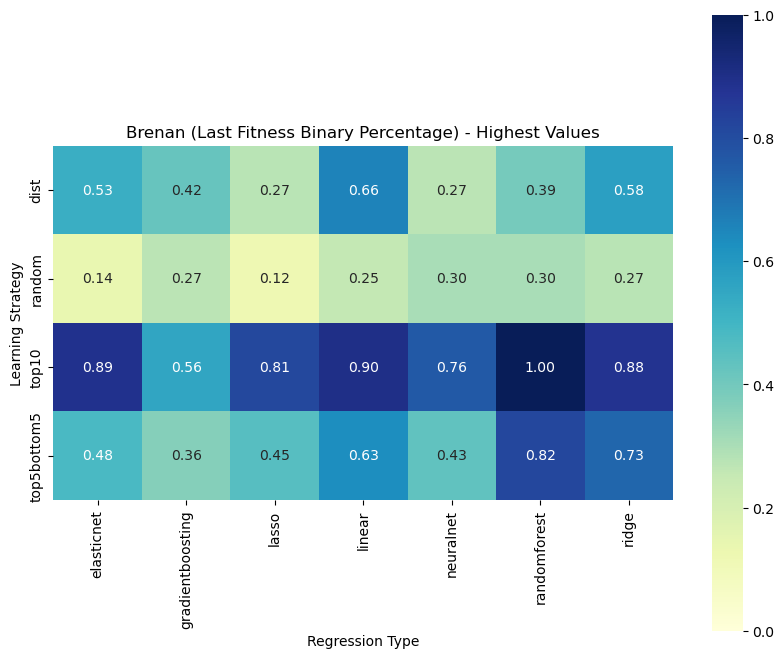

In [12]:
generate_heatmap(df_results, 'last_fitness_binary_percentage', 'Brenan (Last Fitness Binary Percentage) - Highest Values')

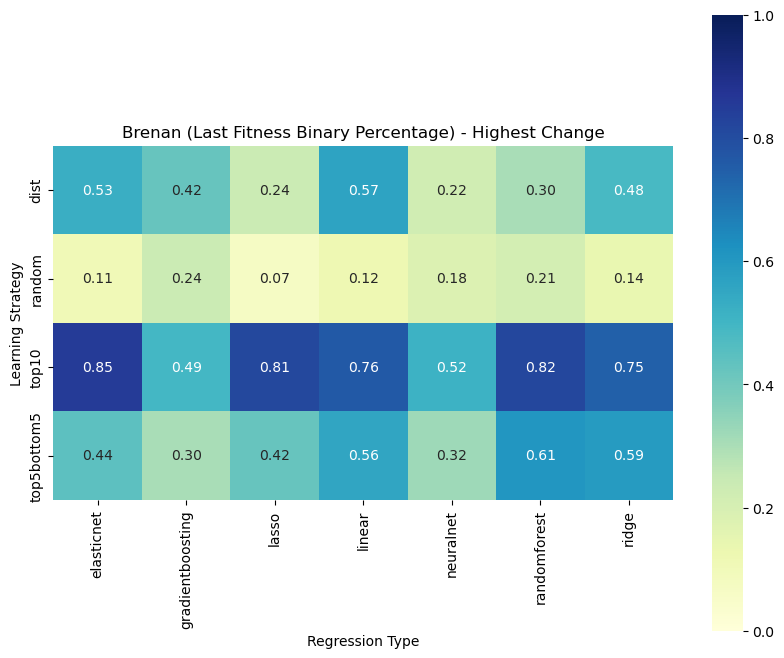

In [13]:
generate_heatmap(df_results, 'change_fitness_binary_percentage', 'Brenan (Last Fitness Binary Percentage) - Highest Change')

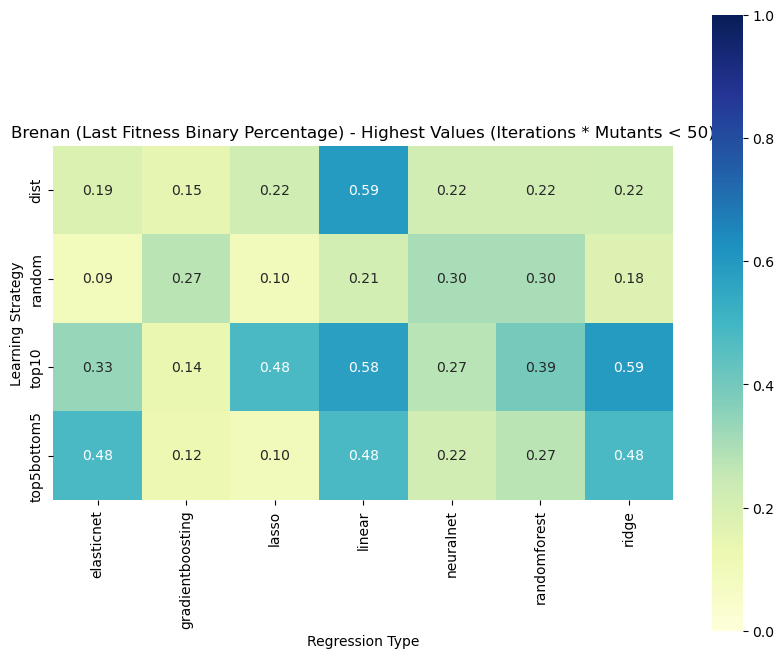

In [14]:
df_results_subset = df_results[(df_results['num_iterations'] * df_results['num_mutants_per_round']) < 50]
generate_heatmap(df_results_subset, 'last_fitness_binary_percentage', 'Brenan (Last Fitness Binary Percentage) - Highest Values (Iterations * Mutants < 50)')


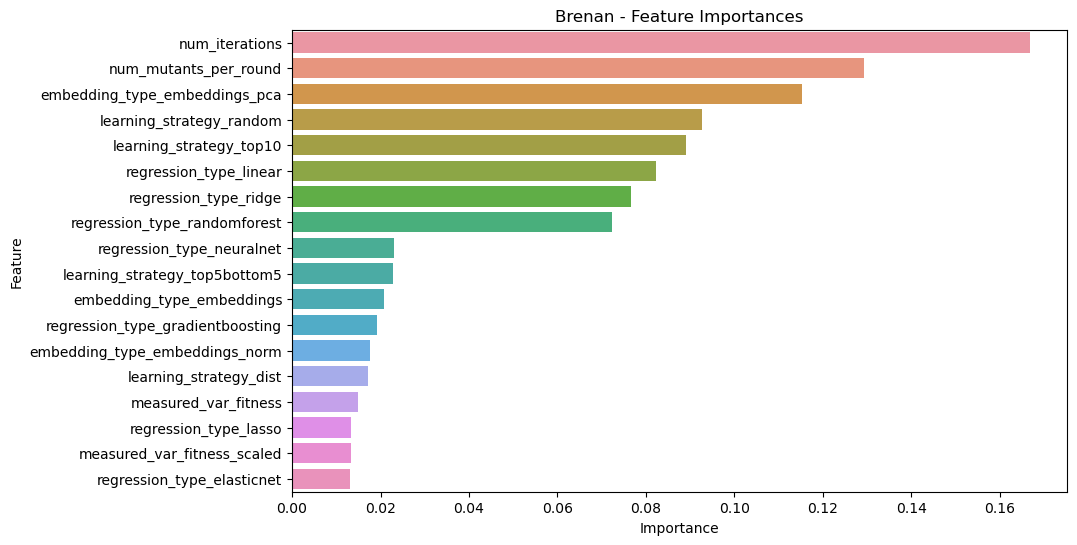

In [15]:
perform_feature_importance(df_results, 'last_fitness_binary_percentage', 'Brenan - Feature Importances')

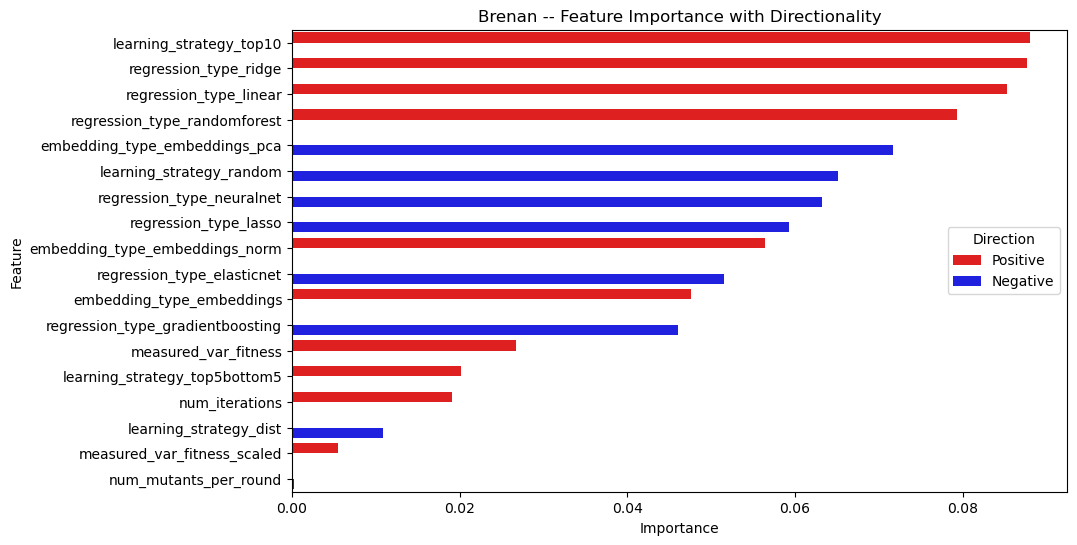

In [16]:
perform_feature_importance_with_directionality(df_results, 'last_fitness_binary_percentage', 'Brenan -- Feature Importance with Directionality')

## Highest occuring variables in grid search

In [77]:
def generate_comparison_plot(dataframes, subset, output_variable, comparison_data, comparison_variable):
    """
    Generate a comparison plot for a given subset of data and an output variable.

    Args:
        dataframes (list): List of input dataframes.
        subset (dict): Dictionary specifying the subset conditions as column-value pairs.
        output_variable (str): Name of the output variable column.

    Returns:
        None (displays the plot).

    """

    # Filter the dataframes based on the subset conditions
    filtered_dfs = []
    for df in dataframes:
        df_subset = df.copy()
        for col, val in subset.items():
            df_subset = df_subset[df_subset[col] == val]
        filtered_dfs.append(df_subset)

    # Concatenate the filtered dataframes
    df_filtered = pd.concat(filtered_dfs, ignore_index=True)
    df_filtered = pd.merge(df_filtered, comparison_data, on='dataset', how='left')

    # Set the width of each bar
    bar_width = 0.35

    # Create the x-axis positions for the bars
    x = np.arange(len(df_filtered))

    # Create subplots for each dataset
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars for 'hie_hit_rate'
    ax.bar(x, df_filtered[comparison_variable], width=bar_width, label=comparison_variable)

    # Plot the bars for the output variable
    ax.bar(x + bar_width, df_filtered[output_variable], width=bar_width, label=output_variable)

    # Set the x-axis ticks and labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(df_filtered['dataset'])
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of ' + comparison_variable + ' and ' + output_variable)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

    return df_filtered


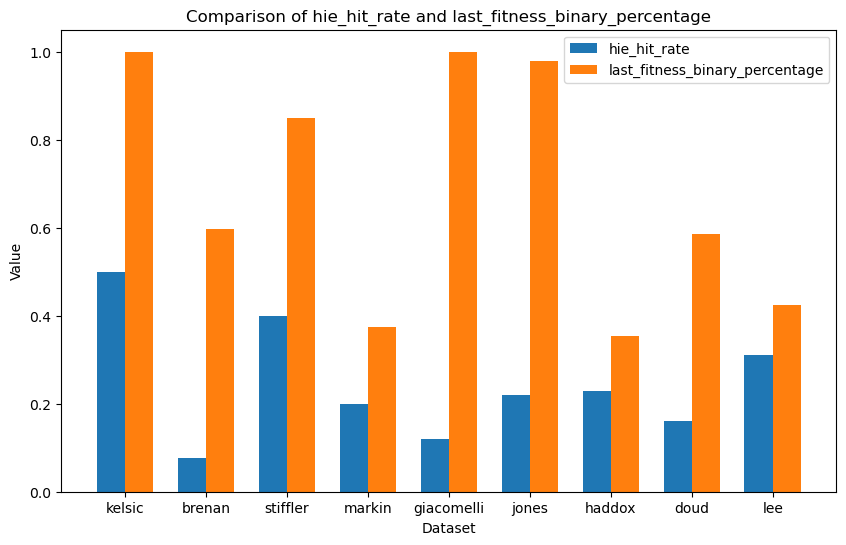

,num_iterations,measured_var,learning_strategy,num_mutants_per_round,embedding_type,regression_type,first_median_fitness_scaled,first_fitness_binary_percentage,last_median_fitness_scaled,last_fitness_binary_percentage,change_median_fitness_scaled,change_fitness_binary_percentage,dataset,hie_hit_rate
0,10,fitness_scaled,top10,32,embeddings,randomforest,0.903292,0.585859,0.931915,1.000000,0.028623,0.414141,kelsic,0.500
1,10,fitness_scaled,top10,32,embeddings,randomforest,0.347282,0.090909,0.649352,0.595960,0.302070,0.505051,brenan,0.077
2,10,fitness_scaled,top10,32,embeddings,randomforest,0.907414,0.242424,0.922368,0.848485,0.014954,0.606061,stiffler,0.400
3,10,fitness_scaled,top10,32,embeddings,randomforest,0.289280,0.070707,0.433940,0.373737,0.144660,0.303030,markin,0.200
4,10,fitness_scaled,top10,32,embeddings,randomforest,0.736139,0.333333,0.835361,1.000000,0.099222,0.666667,giacomelli,0.120
5,10,fitness_scaled,top10,32,embeddings,randomforest,0.336704,0.272727,0.535382,0.979798,0.198678,0.707071,jones,0.220
6,10,fitness_scaled,top10,32,embeddings,randomforest,0.100512,0.050505,0.186573,0.353535,0.086062,0.303030,haddox,0.230
7,10,fitness_scaled,top10,32,embeddings,randomforest,0.063579,0.070707,0.202398,0.585859,0.138818,0.515152,doud,0.160
8,10,fitness_scaled,top10,32,embeddings,randomforest,0.003507,0.080808,0.089762,0.424242,0.086256,0.343434,lee,0.310


In [78]:
# Usage example
subset_conditions = {
    'num_iterations': 10,
    'num_mutants_per_round': 32,
    'measured_var': 'fitness_scaled',
    'embedding_type': 'embeddings',
    'learning_strategy': 'top10',
    'regression_type': 'randomforest'
}

generate_comparison_plot(dfs, subset_conditions, 'last_fitness_binary_percentage', hie_data, 'hie_hit_rate')

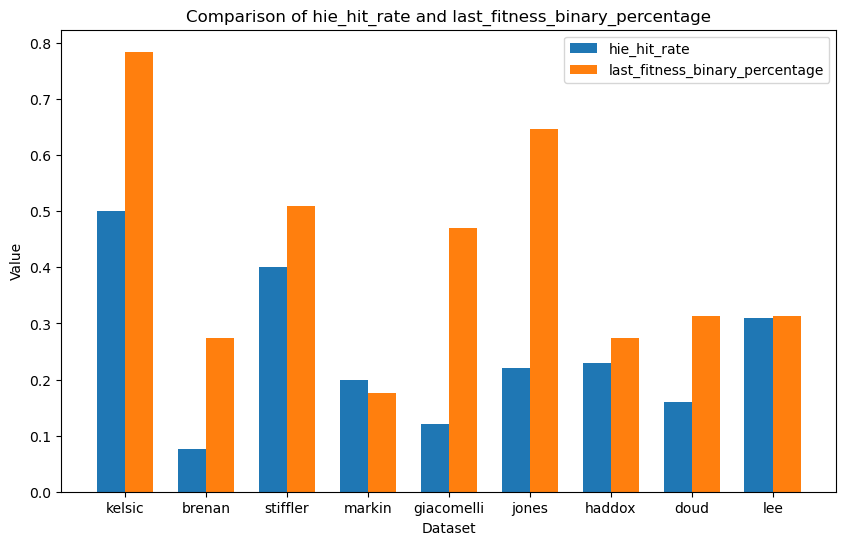

,num_iterations,measured_var,learning_strategy,num_mutants_per_round,embedding_type,regression_type,first_median_fitness_scaled,first_fitness_binary_percentage,last_median_fitness_scaled,last_fitness_binary_percentage,change_median_fitness_scaled,change_fitness_binary_percentage,dataset,hie_hit_rate
0,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.881616,0.352941,0.915210,0.784314,0.033594,0.431373,kelsic,0.500
1,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.362151,0.156863,0.514414,0.274510,0.152262,0.117647,brenan,0.077
2,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.861443,0.156863,0.916303,0.509804,0.054860,0.352941,stiffler,0.400
3,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.270411,0.098039,0.364755,0.176471,0.094343,0.078431,markin,0.200
4,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.728807,0.254902,0.764138,0.470588,0.035331,0.215686,giacomelli,0.120
5,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.326186,0.313725,0.458351,0.647059,0.132165,0.333333,jones,0.220
6,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.073821,0.039216,0.143663,0.274510,0.069843,0.235294,haddox,0.230
7,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.068507,0.137255,0.163343,0.313725,0.094837,0.176471,doud,0.160
8,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.011816,0.137255,0.040889,0.313725,0.029073,0.176471,lee,0.310


In [79]:
# Usage example
subset_conditions = {
    'num_iterations': 5,
    'num_mutants_per_round': 16,
    'measured_var': 'fitness_scaled',
    'embedding_type': 'embeddings_pca',
    'learning_strategy': 'top10',
    'regression_type': 'randomforest'
}

generate_comparison_plot(dfs, subset_conditions, 'last_fitness_binary_percentage', hie_data, 'hie_hit_rate')

In [80]:
def select_top_values(datasets, column_name, n):
    """
    Select the top n values from each dataset based on a specified column.

    Args:
        datasets (list): List of dataset names.
        column_name (str): Name of the column to rank by.
        n (int): Number of top values to select.

    Returns:
        pandas.DataFrame: A new dataframe containing the 'dataset', 'last_fitness_binary_percentage',
            and 'last_median_fitness' columns for the top n values in each dataset.

    """
    selected_dfs = []

    for dataset in datasets:
        csv_filename = f"labels/{dataset}_labels.csv"
        df = pd.read_csv(csv_filename)

        # Rank the dataframe by the specified column in descending order
        ranked_df = df.sort_values(by=column_name, ascending=False)

        # Select the top n values
        top_values = ranked_df.head(n)

        # compute the median fitness for the top n values
        median_fitness = top_values['fitness_scaled'].median()

        # compute the binary percentage for the top n values
        binary_percentage = top_values['fitness_binary'].mean()

        # Create a new dataframe with the desired columns
        selected_df = pd.DataFrame({
            'dataset': [dataset],
            'last_fitness_binary_percentage_comparative': [binary_percentage],
            'last_median_fitness_comparative': [median_fitness]
        })

        selected_dfs.append(selected_df)

    # Concatenate the selected dataframes into a single dataframe
    result_df = pd.concat(selected_dfs)

    return result_df


In [81]:
# Usage example
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli']
column_name = 'DeepSequence'  # Replace with the actual column name

selected_data_10 = select_top_values(datasets, column_name, 10)
selected_data_5 = select_top_values(datasets, column_name, 5)

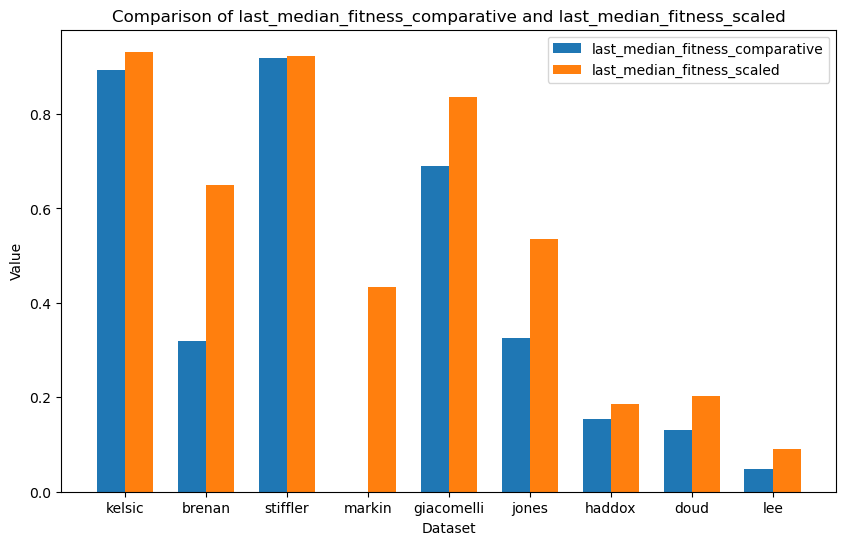

,num_iterations,measured_var,learning_strategy,num_mutants_per_round,embedding_type,regression_type,first_median_fitness_scaled,first_fitness_binary_percentage,last_median_fitness_scaled,last_fitness_binary_percentage,change_median_fitness_scaled,change_fitness_binary_percentage,dataset,last_fitness_binary_percentage_comparative,last_median_fitness_comparative
0,10,fitness_scaled,top10,32,embeddings,randomforest,0.903292,0.585859,0.931915,1.000000,0.028623,0.414141,kelsic,0.4,0.894206
1,10,fitness_scaled,top10,32,embeddings,randomforest,0.347282,0.090909,0.649352,0.595960,0.302070,0.505051,brenan,0.0,0.318785
2,10,fitness_scaled,top10,32,embeddings,randomforest,0.907414,0.242424,0.922368,0.848485,0.014954,0.606061,stiffler,0.6,0.918466
3,10,fitness_scaled,top10,32,embeddings,randomforest,0.289280,0.070707,0.433940,0.373737,0.144660,0.303030,markin,NaN,NaN
4,10,fitness_scaled,top10,32,embeddings,randomforest,0.736139,0.333333,0.835361,1.000000,0.099222,0.666667,giacomelli,0.2,0.690874
5,10,fitness_scaled,top10,32,embeddings,randomforest,0.336704,0.272727,0.535382,0.979798,0.198678,0.707071,jones,0.1,0.325393
6,10,fitness_scaled,top10,32,embeddings,randomforest,0.100512,0.050505,0.186573,0.353535,0.086062,0.303030,haddox,0.2,0.154381
7,10,fitness_scaled,top10,32,embeddings,randomforest,0.063579,0.070707,0.202398,0.585859,0.138818,0.515152,doud,0.4,0.130428
8,10,fitness_scaled,top10,32,embeddings,randomforest,0.003507,0.080808,0.089762,0.424242,0.086256,0.343434,lee,0.4,0.047863


In [82]:
# Usage example
subset_conditions = {
    'num_iterations': 10,
    'num_mutants_per_round': 32,
    'measured_var': 'fitness_scaled',
    'embedding_type': 'embeddings',
    'learning_strategy': 'top10',
    'regression_type': 'randomforest'
}

generate_comparison_plot(dfs, subset_conditions, 'last_median_fitness_scaled', selected_data_10, 'last_median_fitness_comparative')

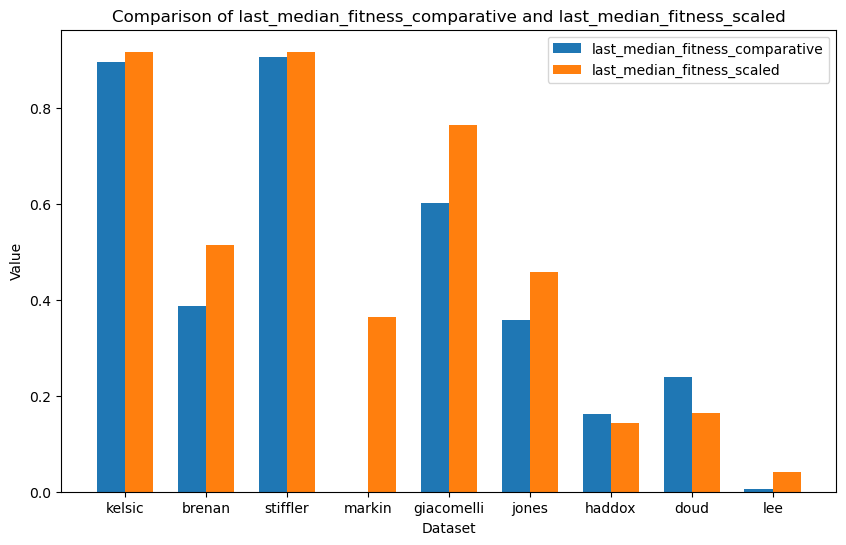

,num_iterations,measured_var,learning_strategy,num_mutants_per_round,embedding_type,regression_type,first_median_fitness_scaled,first_fitness_binary_percentage,last_median_fitness_scaled,last_fitness_binary_percentage,change_median_fitness_scaled,change_fitness_binary_percentage,dataset,last_fitness_binary_percentage_comparative,last_median_fitness_comparative
0,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.881616,0.352941,0.915210,0.784314,0.033594,0.431373,kelsic,0.4,0.894756
1,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.362151,0.156863,0.514414,0.274510,0.152262,0.117647,brenan,0.0,0.386114
2,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.861443,0.156863,0.916303,0.509804,0.054860,0.352941,stiffler,0.4,0.905342
3,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.270411,0.098039,0.364755,0.176471,0.094343,0.078431,markin,NaN,NaN
4,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.728807,0.254902,0.764138,0.470588,0.035331,0.215686,giacomelli,0.0,0.601054
5,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.326186,0.313725,0.458351,0.647059,0.132165,0.333333,jones,0.2,0.358584
6,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.073821,0.039216,0.143663,0.274510,0.069843,0.235294,haddox,0.2,0.162130
7,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.068507,0.137255,0.163343,0.313725,0.094837,0.176471,doud,0.6,0.238321
8,5,fitness_scaled,top10,16,embeddings_pca,randomforest,0.011816,0.137255,0.040889,0.313725,0.029073,0.176471,lee,0.4,0.004860


In [83]:
# Usage example
subset_conditions = {
    'num_iterations': 5,
    'num_mutants_per_round': 16,
    'measured_var': 'fitness_scaled',
    'embedding_type': 'embeddings_pca',
    'learning_strategy': 'top10',
    'regression_type': 'randomforest'
}

generate_comparison_plot(dfs, subset_conditions, 'last_median_fitness_scaled', selected_data_5, 'last_median_fitness_comparative')